# Resnet152 with cropped images
Alternating between normal and cropped images. The number of epochs doubled no increase in accuracy. 
Other thing to try out is one at a time, also be car

In [1]:
import pandas as pd
from pathlib import Path
from scipy.io import loadmat
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
from fastai import *
from fastai.vision import *

In [42]:
#!mv data/cars_train data/train
#!mv data/cars_test data/test

In [11]:
#!wget https://ai.stanford.edu/~jkrause/cars/car_devkit.tgz
#!tar -zxvf car_devkit.tgz -C data

--2019-06-05 09:04:47--  https://ai.stanford.edu/~jkrause/cars/car_devkit.tgz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 330960 (323K) [application/x-gzip]
Saving to: ‘car_devkit.tgz’

car_devkit.tgz      100%[===================>] 323.20K   207KB/s    in 1.6s    

2019-06-05 09:04:50 (207 KB/s) - ‘car_devkit.tgz’ saved [330960/330960]



In [319]:
#!wget http://imagenet.stanford.edu/internal/car196/cars_test_annos_withlabels.mat
#!mv cars_test_annos_withlabels.mat data/

--2019-06-05 15:42:06--  http://imagenet.stanford.edu/internal/car196/cars_test_annos_withlabels.mat
Resolving imagenet.stanford.edu (imagenet.stanford.edu)... 171.64.68.16
Connecting to imagenet.stanford.edu (imagenet.stanford.edu)|171.64.68.16|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 185758 (181K) [text/plain]
Saving to: ‘cars_test_annos_withlabels.mat.1’

cars_test_annos_wit 100%[===================>] 181.40K   134KB/s    in 1.4s    

2019-06-05 15:42:08 (134 KB/s) - ‘cars_test_annos_withlabels.mat.1’ saved [185758/185758]



Create a unified folder where test images and train images are in for fastai learner to test at the end of training

In [418]:
#!mkdir data/all_img
#!cp -a data/test/. data/all_img    
#cd data/all_img && rename 's/^/test_/' *  # renaming all the test images in the folder with 'test' suffix
#!cp -a data/train/. data/all_img   

In [3]:
train_path = 'data/train/'
cropped_path = 'data/cropped_train/'
test_path = 'data/test/'
all_img_path = 'data/all_img'
CROPPED_PATH = Path(cropped_path)

In [ ]:
#CROPPED_PATH.mkdir(parents=True, exist_ok=True)

Fixed code from [Devon from Kaggle](https://www.kaggle.com/criticalmassacre/inaccurate-labels-in-stanford-cars-data-set) 

In [4]:
train_an_pth = 'data/devkit/cars_train_annos.mat'
test_an_pth = 'data/cars_test_annos_withlabels.mat'
classes_pth = 'data/devkit/cars_meta.mat'

def get_labels(annos_path, classes_path):
    car_an = loadmat(annos_path)
    car_meta = loadmat(classes_path)
    annotations = car_an["annotations"][0,:]
    total_classes = len(car_meta["class_names"][0])
    class_names = dict(zip(range(1,total_classes+1),[c[0] for c in car_meta["class_names"][0]]))
    
    labelled_images = {}
    dataset = []
    for arr in annotations:
        # the last entry in the row is the image name
        # The rest is the data, first bbox, then classid
        dataset.append([y[0][0] for y in arr][0:5]+[arr[5][0]])
    # Convert to a DataFrame, and specify the column names
    temp_df = pd.DataFrame(dataset, 
                      columns =['BBOX_X1','BBOX_Y1','BBOX_X2','BBOX_Y2','ClassID','filename'])

    temp_df = temp_df.assign(ClassName=temp_df.ClassID.map(dict(class_names)))
    temp_df.columns = ['bbox_x1','bbox_y1','bbox_x2','bbox_y2','class_id','filename', 'class_name']
    return temp_df

In [179]:
train_df = get_labels(train_an_pth, classes_pth)
train_df['test'] = 0
train_df.head()

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class_id,filename,class_name,test
0,39,116,569,375,14,00001.jpg,Audi TTS Coupe 2012,0
1,36,116,868,587,3,00002.jpg,Acura TL Sedan 2012,0
2,85,109,601,381,91,00003.jpg,Dodge Dakota Club Cab 2007,0
3,621,393,1484,1096,134,00004.jpg,Hyundai Sonata Hybrid Sedan 2012,0
4,14,36,133,99,106,00005.jpg,Ford F-450 Super Duty Crew Cab 2012,0


In [180]:
test_df = get_labels(test_an_pth,classes_pth)
test_df['test'] = 1
test_df.head()

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class_id,filename,class_name,test
0,30,52,246,147,181,00001.jpg,Suzuki Aerio Sedan 2007,1
1,100,19,576,203,103,00002.jpg,Ferrari 458 Italia Convertible 2012,1
2,51,105,968,659,145,00003.jpg,Jeep Patriot SUV 2012,1
3,67,84,581,407,187,00004.jpg,Toyota Camry Sedan 2012,1
4,140,151,593,339,185,00005.jpg,Tesla Model S Sedan 2012,1


In [181]:
test_df_all_img = test_df.copy()
test_df_all_img['filename'] = test_df_all_img['filename'].map(lambda x: f'test_{x}')
test_df_all_img.head()

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class_id,filename,class_name,test
0,30,52,246,147,181,test_00001.jpg,Suzuki Aerio Sedan 2007,1
1,100,19,576,203,103,test_00002.jpg,Ferrari 458 Italia Convertible 2012,1
2,51,105,968,659,145,test_00003.jpg,Jeep Patriot SUV 2012,1
3,67,84,581,407,187,test_00004.jpg,Toyota Camry Sedan 2012,1
4,140,151,593,339,185,test_00005.jpg,Tesla Model S Sedan 2012,1


In [182]:
all_img_df = pd.concat([train_df,test_df_all_img])
all_img_df = all_img_df.loc[:,['filename', 'class_name', 'class_id', 'test']]
#all_img_df.to_csv('all_img.csv',index=False)

In [30]:
#Add cropped file names 
train_df['filename_cropped'] = train_df['filename'].map(lambda x: f'cropped_{x}')
#train_df.to_csv('train_labels.csv',index=False)

In [31]:
#Ensuring class names and class ids are mapped properly 
train_df['class_name'].nunique(), train_df['class_id'].nunique()

(196, 196)

In [32]:
train_df.head()

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class_id,filename,class_name,test,filename_cropped
0,39,116,569,375,14,00001.jpg,Audi TTS Coupe 2012,0,cropped_00001.jpg
1,36,116,868,587,3,00002.jpg,Acura TL Sedan 2012,0,cropped_00002.jpg
2,85,109,601,381,91,00003.jpg,Dodge Dakota Club Cab 2007,0,cropped_00003.jpg
3,621,393,1484,1096,134,00004.jpg,Hyundai Sonata Hybrid Sedan 2012,0,cropped_00004.jpg
4,14,36,133,99,106,00005.jpg,Ford F-450 Super Duty Crew Cab 2012,0,cropped_00005.jpg


In [275]:
def _crop(df, path, i):
    img = Image.open(path + df['filename'][i])
    x1 = df['bbox_x1'][i]
    y1 =df['bbox_y1'][i]
    y2 = df['bbox_y2'][i]
    x2 = df['bbox_x2'][i]
    bbox = (x1,y1,x2,y2)
    return img.crop(bbox)

def save(img,df,path,i): 
    return img.save(f'{path + df["filename_cropped"][i]}')
                    
def get_cropped_image(df,path,cropped_path,i):
    cropped = _crop(df,path,i)
    return save(cropped,df,cropped_path,i)
    

In [ ]:
#Generate cropped images
#list(map(lambda x: get_cropped_image(train_df,train_path,cropped_path,x), list(range(len(train_df)))))

#### Commence training: Stage-1 (resnet152)
- Setting up data bunch and transformations

In [13]:
tfms = get_transforms()
trn_df_labels = train_df[['filename','class_name']]

src = (ImageList.from_df(trn_df_labels,train_path, cols='filename')
       .split_by_rand_pct(0.2, seed=42).label_from_df('class_name'))

In [14]:
data128 = (src.transform(tfms,size=128).databunch(bs=64).normalize(imagenet_stats))

In [15]:
learn = cnn_learner(data128,models.resnet152,metrics=[error_rate,accuracy, Precision(average='weighted'), Recall(average='weighted')])

In [16]:
learn.lr_find(wd=1e-3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-03


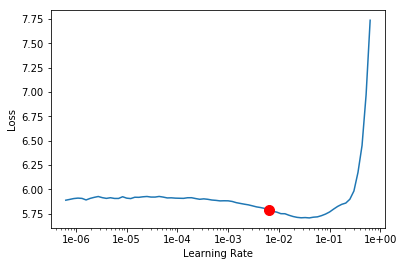

In [17]:
learn.recorder.plot(suggestion=True)

In [21]:
learn.fit_one_cycle(5, 1e-2,wd=1e-3)

epoch,train_loss,valid_loss,error_rate,accuracy,precision,recall,time
0,2.013381,3.694886,0.782555,0.217445,nan,0.217445,00:58
1,2.791586,2.962861,0.725430,0.274570,nan,0.274570,00:59
2,2.396882,2.283252,0.581695,0.418305,nan,0.418305,00:59
3,1.829580,1.577860,0.421990,0.578010,0.634760,0.578010,00:59
4,1.373731,1.420316,0.393120,0.606880,0.644691,0.606880,00:59


In [20]:
learn.save('3-resnet-152-128-v1-5ep-lr1e-2-wd1e-3')

#### Stage-2
- Unfreezing the model to train body's weight

In [22]:
#Load the best model from stage-1
learn.load('3-resnet-152-128-v1-5ep-lr1e-2-wd1e-3');

In [23]:
learn.unfreeze()

In [25]:
learn.lr_find(wd=1e-3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


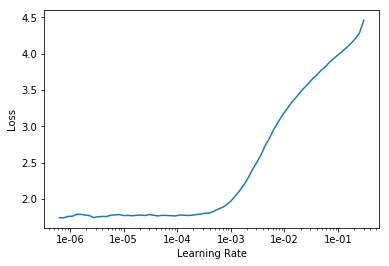

In [26]:
learn.recorder.plot()

In [27]:
learn.fit_one_cycle(5, max_lr=slice(1e-6,3e-4),wd=1e-3)

epoch,train_loss,valid_loss,error_rate,accuracy,precision,recall,time
0,1.739431,1.758056,0.458845,0.541155,0.575126,0.541155,01:12
1,1.672987,1.694382,0.448403,0.551597,0.598005,0.551597,01:12
2,1.497799,1.583202,0.414005,0.585995,0.620193,0.585995,01:12
3,1.383846,1.507790,0.396806,0.603194,0.636714,0.603194,01:13
4,1.261193,1.505878,0.405405,0.594595,0.626348,0.594595,01:13


In [28]:
learn.save('3-resnet-152-128-v2-5ep-lr1e-6,3e-4-wd1e-3')

#### Stage-3 
- with cropped images

In [87]:
cropped_src = (ImageList.from_df(train_df,cropped_path, cols='filename_cropped')
       .split_by_rand_pct(0.2, seed=42).label_from_df('class_name'))

In [88]:
cropped_data128 = (cropped_src.transform(get_transforms(max_zoom=1.),size=128).databunch(bs=64).normalize(imagenet_stats))

In [89]:
learn.load('3-resnet-152-128-v2-5ep-lr1e-6,3e-4-wd1e-3');

In [90]:
learn.data = cropped_data128

In [91]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


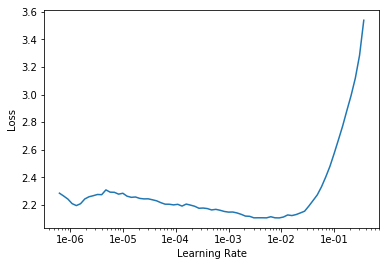

In [92]:
learn.lr_find(wd=1e-3)
learn.recorder.plot()

In [93]:
learn.fit_one_cycle(5,1e-2,wd=1e-3)

epoch,train_loss,valid_loss,error_rate,accuracy,precision,recall,time
0,2.138529,3.287102,0.745700,0.254300,nan,0.254300,00:56
1,2.699991,3.493646,0.757985,0.242015,nan,0.242015,00:54
2,2.289794,2.103782,0.539926,0.460074,nan,0.460074,00:54
3,1.741220,1.388940,0.380835,0.619165,0.677422,0.619165,00:54
4,1.377719,1.271232,0.348894,0.651106,0.692314,0.651106,00:53


In [94]:
learn.save('3-resnet152-v1-cropped128-5ep-lr1e-2-wd1e-3')

### Stage 4
- Unfreezing model for cropped image

In [95]:
learn.load('3-resnet152-v1-cropped128-5ep-lr1e-2-wd1e-3');

In [96]:
learn.unfreeze()

In [97]:
learn.lr_find(wd=1e-3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


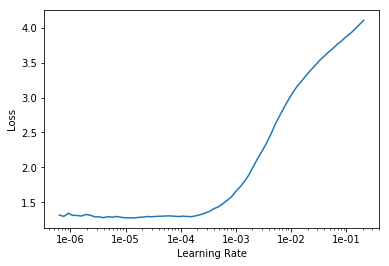

In [98]:
learn.recorder.plot()

In [99]:
learn.fit_one_cycle(5,slice(1e-6,3e-4),wd=1e-3)

epoch,train_loss,valid_loss,error_rate,accuracy,precision,recall,time
0,1.224101,1.242659,0.346437,0.653563,0.687040,0.653563,01:09
1,1.193846,1.204270,0.326781,0.673219,0.709055,0.673219,01:08
2,1.114224,1.140540,0.306511,0.693489,0.727093,0.693489,01:08
3,1.005404,1.075678,0.292383,0.707617,0.735870,0.707617,01:08
4,0.958708,1.070176,0.293612,0.706388,0.737039,0.706388,01:08


In [100]:
learn.save('3-resnet152-v2-cropped128-5ep-lr1e-6,3e-4-wd1e-3')

### Stage 5 
- resized to 224

In [101]:
learn.load('3-resnet152-v2-cropped128-5ep-lr1e-6,3e-4-wd1e-3');

In [102]:
data224= (src.transform(tfms,size=224).databunch(bs=32).normalize(imagenet_stats))

In [103]:
learn.data = data224

In [104]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


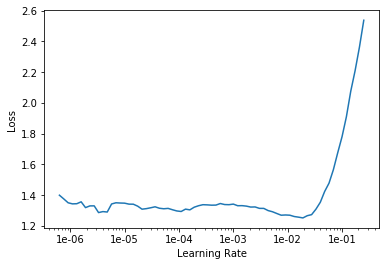

In [105]:
learn.lr_find()
learn.recorder.plot()

In [106]:
learn.fit_one_cycle(5,3e-3,wd=1e-3)

epoch,train_loss,valid_loss,error_rate,accuracy,precision,recall,time
0,1.038781,1.040930,0.285012,0.714988,nan,0.714988,02:32
1,1.118161,1.034068,0.288698,0.711302,0.776620,0.711302,02:33
2,0.951176,0.879436,0.254300,0.745700,0.788107,0.745700,02:31
3,0.630489,0.736352,0.202088,0.797912,0.820987,0.797912,02:32
4,0.507228,0.711955,0.199631,0.800369,0.820177,0.800369,02:33


In [107]:
learn.save('3-resnet152-v1-224-5ep-lr3e-3-wd1e-3')

#### Stage-6
- Unfreezing the model for data sized 224

In [108]:
learn.load('3-resnet152-v1-224-5ep-lr3e-3-wd1e-3');

In [109]:
learn.unfreeze()

In [110]:
learn.lr_find(wd=1e-3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


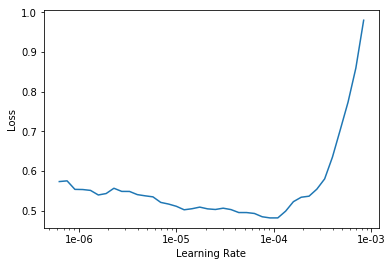

In [111]:
learn.recorder.plot()

In [112]:
learn.fit_one_cycle(5,slice(3e-6,1e-4),wd=1e-3)

epoch,train_loss,valid_loss,error_rate,accuracy,precision,recall,time
0,0.522418,0.743402,0.211916,0.788084,0.813446,0.788084,03:17
1,0.596078,0.743302,0.210074,0.789926,0.815516,0.789926,03:19
2,0.510956,0.703305,0.197174,0.802826,0.823784,0.802826,03:18
3,0.419995,0.652623,0.186118,0.813882,0.831880,0.813882,03:19
4,0.368820,0.643411,0.183661,0.816339,0.835844,0.816339,03:18


In [113]:
learn.save('3-resnet152-v2-224-5ep-lr3e-6,1e-4-wd1e-3')

#### Stage-7
- with cropped images 224

In [116]:
cropped_data224 = (cropped_src.transform(get_transforms(max_zoom=1.),size=224).databunch(bs=32).normalize(imagenet_stats))

In [117]:
learn.data = cropped_data224

In [36]:
#To free up some memory
learn.purge;

In [124]:
learn.load('3-resnet152-v2-224-5ep-lr3e-6,1e-4-wd1e-3');

In [120]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


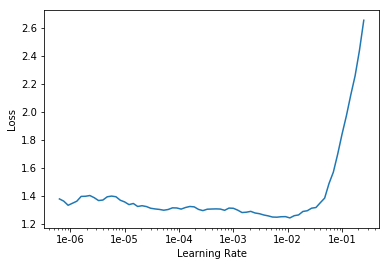

In [121]:
learn.lr_find(wd=1e-3)
learn.recorder.plot()

In [122]:
learn.fit_one_cycle(5,1e-2,wd=1e-3)

epoch,train_loss,valid_loss,error_rate,accuracy,precision,recall,time
0,1.452858,2.443820,0.568796,0.431204,nan,0.431204,02:30
1,2.167296,2.061477,0.506142,0.493858,nan,0.493858,02:30
2,1.707191,1.473007,0.407248,0.592752,nan,0.592752,02:31
3,1.109409,0.975648,0.282555,0.717445,nan,0.717445,02:30
4,0.862680,0.854844,0.248772,0.751229,0.773108,0.751228,02:30


In [125]:
learn.fit_one_cycle(5,3e-3,wd=1e-3)

epoch,train_loss,valid_loss,error_rate,accuracy,precision,recall,time
0,0.977701,1.158290,0.309582,0.690418,0.732649,0.690418,02:30
1,1.067738,1.169689,0.323096,0.676904,nan,0.676904,02:31
2,0.937942,0.970014,0.259828,0.740172,0.776676,0.740172,02:31
3,0.741436,0.851953,0.235872,0.764128,0.793535,0.764128,02:30
4,0.629359,0.809090,0.223587,0.776413,0.800145,0.776413,02:31


In [126]:
learn.save('3-resnet152-v1-cropped224-5ep-lr3e-3-wd1e-3')

### Stage 8
- Unfreezing model for cropped image 224

In [144]:
learn.load('3-resnet152-v1-cropped224-5ep-lr3e-3-wd1e-3');

In [145]:
learn.unfreeze()

In [146]:
learn.lr_find(wd=1e-3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


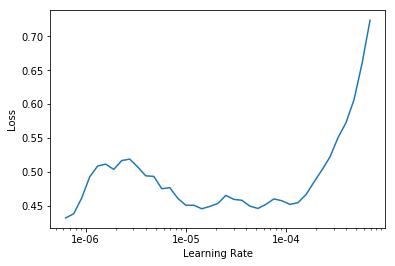

In [147]:
learn.recorder.plot()

In [148]:
learn.fit_one_cycle(5,slice(1e-5,1e-4),wd=1e-3)

epoch,train_loss,valid_loss,error_rate,accuracy,precision,recall,time
0,0.368552,0.587306,0.171376,0.828624,0.851205,0.828624,03:15
1,0.359638,0.596699,0.174447,0.825553,0.847128,0.825553,03:16
2,0.202578,0.498603,0.140049,0.859951,0.874086,0.859951,03:16
3,0.112822,0.454683,0.125921,0.874079,0.889783,0.874079,03:15
4,0.077992,0.455804,0.122850,0.877150,0.893526,0.877150,03:16


In [149]:
learn.save('3-resnet152-v2-cropped224-5ep-lr1e-4,1e-4-wd1e-3')

#### Stage-9
- Last resizing to 299 

In [ ]:
learn.purge;

In [151]:
learn.load('3-resnet152-v2-cropped224-5ep-lr1e-4,1e-4-wd1e-3');

In [152]:
data299 = (src.transform(tfms,size=299).databunch(bs=16).normalize(imagenet_stats))

In [153]:
learn.data = data299

In [154]:
learn.freeze()

In [156]:
learn.lr_find(wd=1e-3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


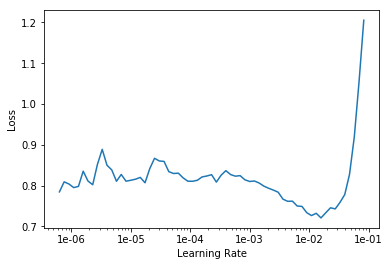

In [157]:
learn.recorder.plot()

In [158]:
learn.fit_one_cycle(5,3e-3,wd=1e-3)

epoch,train_loss,valid_loss,error_rate,accuracy,precision,recall,time
0,0.531425,0.704516,0.188575,0.811425,0.839868,0.811425,04:50
1,0.944315,0.970136,0.259828,0.740172,nan,0.740172,04:48
2,0.658982,0.704651,0.188575,0.811425,0.840696,0.811425,04:48
3,0.423920,0.577866,0.152334,0.847666,0.862954,0.847666,04:47
4,0.319245,0.563733,0.150491,0.849509,0.864729,0.849509,04:48


In [159]:
learn.save('3-resnet152-v1-299-5ep-lr3e-3-wd1e-3')

#### Stage-10 
- Unfreezing and last 5 epochs 

In [160]:
learn.load('3-resnet152-v1-299-5ep-lr3e-3-wd1e-3');

In [161]:
learn.unfreeze()

In [162]:
learn.lr_find(wd=1e-3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


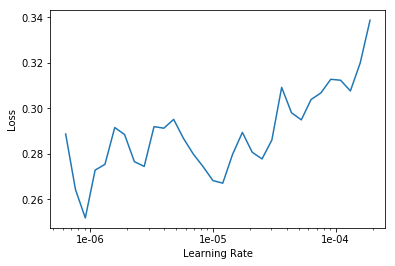

In [163]:
learn.recorder.plot()

In [164]:
learn.fit_one_cycle(5,slice(1e-6,2e-5), wd=0.01)

epoch,train_loss,valid_loss,error_rate,accuracy,precision,recall,time
0,0.315812,0.557246,0.147420,0.852580,0.867337,0.852580,06:18
1,0.313907,0.545517,0.151106,0.848894,0.863925,0.848894,06:19
2,0.289004,0.531201,0.140663,0.859337,0.873708,0.859337,06:19
3,0.240013,0.537993,0.143120,0.856880,0.871107,0.856880,06:19
4,0.246275,0.536013,0.142506,0.857494,0.873622,0.857494,06:19


In [165]:
learn.save('3-resnet152-v2-299-5ep-lr1e-6,2e-5-wd1e-3')

In [166]:
learn.load('3-resnet152-v2-299-5ep-lr1e-6,2e-5-wd1e-3');

In [168]:
learn.lr_find(wd=1e-3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


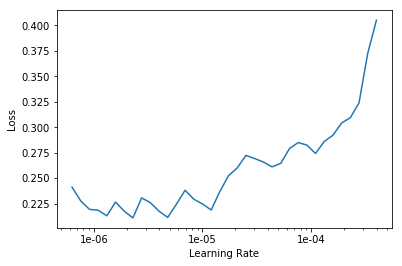

In [170]:
learn.recorder.plot()

In [171]:
learn.fit_one_cycle(5,slice(1e-6,1e-5),wd=1e-3)

epoch,train_loss,valid_loss,error_rate,accuracy,precision,recall,time
0,0.250540,0.529618,0.135135,0.864865,0.877647,0.864865,06:19
1,0.256458,0.521913,0.139435,0.860565,0.872967,0.860565,06:19
2,0.250024,0.524316,0.140663,0.859337,0.873230,0.859337,06:19
3,0.236811,0.515255,0.137592,0.862408,0.876450,0.862408,06:19
4,0.208187,0.508917,0.133292,0.866708,0.878872,0.866708,06:18


In [172]:
learn.save('3-resnet152-v3-299-5ep-lr1e-6,1e-5-wd1e-3')

#### Stage-11
- with cropped images 299

In [188]:
cropped_data299 = (cropped_src.transform(get_transforms(max_zoom=1.),size=299).databunch(bs=16).normalize(imagenet_stats))

In [189]:
learn.data = cropped_data299

In [36]:
#To free up some memory
learn.purge;

In [190]:
learn.load('3-resnet152-v3-299-5ep-lr1e-6,1e-5-wd1e-3');

In [191]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


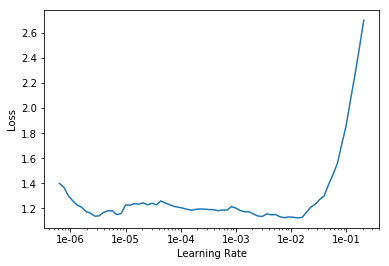

In [192]:
learn.lr_find(wd=1e-3)
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5,3e-3,wd=1e-3)

epoch,train_loss,valid_loss,error_rate,accuracy,precision,recall,time
0,0.954351,1.188087,0.292383,0.707617,0.764854,0.707617,04:47
1,1.081625,1.138938,0.302826,0.697174,0.758877,0.697175,04:47
2,1.023799,0.909028,0.240172,0.759828,0.808124,0.759828,04:47
3,0.649248,0.741627,0.207002,0.792998,0.815193,0.792997,04:46


In [126]:
learn.save('3-resnet152-v1-cropped299-5ep-lr3e-3-wd1e-3')

### Stage 12
- Unfreezing model for cropped image 299

In [144]:
learn.load('3-resnet152-v1-cropped299-5ep-lr3e-3-wd1e-3');

In [145]:
learn.unfreeze()

In [146]:
learn.lr_find(wd=1e-3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


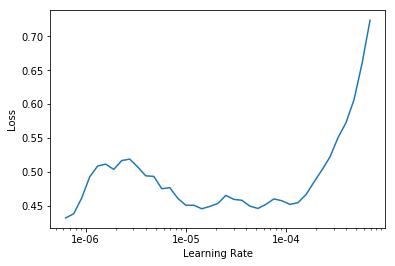

In [147]:
learn.recorder.plot()

In [148]:
learn.fit_one_cycle(5,slice(1e-5,1e-4),wd=1e-3)

epoch,train_loss,valid_loss,error_rate,accuracy,precision,recall,time
0,0.368552,0.587306,0.171376,0.828624,0.851205,0.828624,03:15
1,0.359638,0.596699,0.174447,0.825553,0.847128,0.825553,03:16
2,0.202578,0.498603,0.140049,0.859951,0.874086,0.859951,03:16
3,0.112822,0.454683,0.125921,0.874079,0.889783,0.874079,03:15
4,0.077992,0.455804,0.122850,0.877150,0.893526,0.877150,03:16


In [149]:
learn.save('3-resnet152-v2-cropped224-5ep-lr1e-4,1e-4-wd1e-3')

### Test Set Performance

In [183]:
data_test = (ImageList.from_df(all_img_df,all_img_path,cols='filename')
           .split_from_df(col='test').label_from_df(cols='class_name').transform(tfms,size=299).databunch(bs=64).normalize(imagenet_stats))

In [184]:
learn.load('3-resnet152-v3-299-5ep-lr1e-6,1e-5-wd1e-3');

In [185]:
learn.data = data_test

In [186]:
test_preds, test_ys = learn.TTA()

In [187]:
accuracy(test_preds,test_ys)

tensor(0.8790)

Baseline accuracy will be 87.56% with resnet152